# PART-A:Airbnb Price Prediction and Insights

## 1.Data Exploration and Preprocessing

Shape before cleaning: (74111, 29)
Target column: log_price


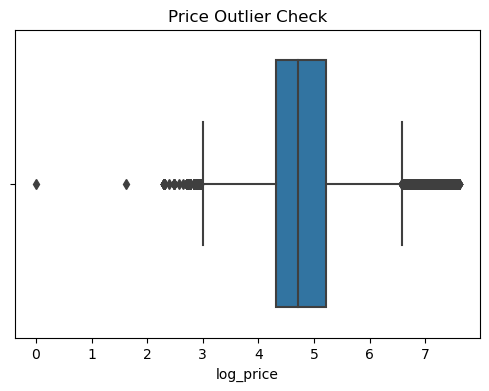

Shape after outlier removal: (72651, 29)


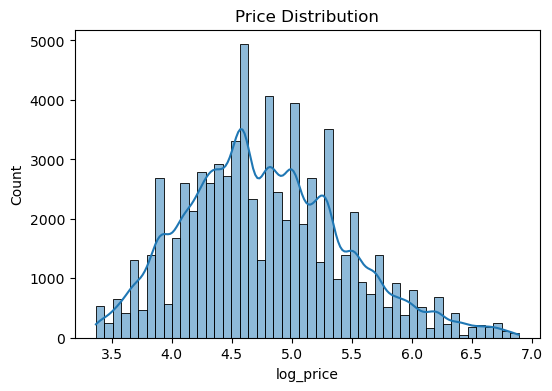

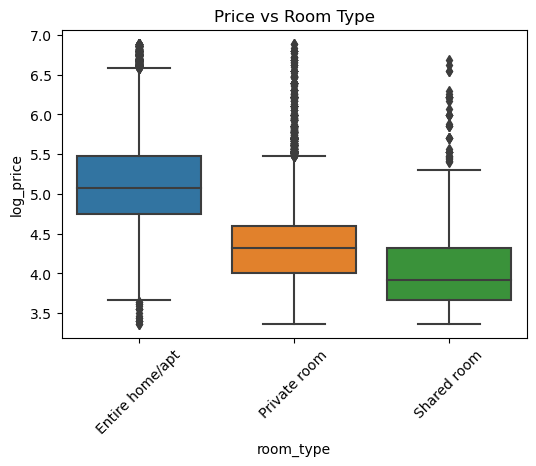

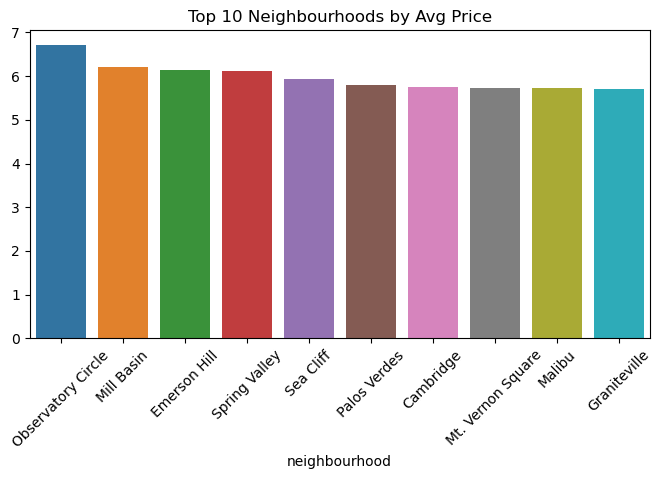

Numeric features: 11 | Categorical features: 18


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("Airbnb_data - airbnb_data.csv")
print("Shape before cleaning:", df.shape)

# Drop duplicates
df = df.drop_duplicates()

# Drop columns with >60% missing values
df = df.drop(columns=[c for c in df.columns if df[c].isna().mean() > 0.6])

# Target column
target_col = [c for c in df.columns if "price" in c.lower()][0]
print("Target column:", target_col)

# --- Outlier Handling (Price) ---
plt.figure(figsize=(6,4))
sns.boxplot(x=df[target_col])
plt.title("Price Outlier Check")
plt.show()

low, high = df[target_col].quantile([0.01, 0.99])
df = df[(df[target_col] >= low) & (df[target_col] <= high)]
print("Shape after outlier removal:", df.shape)

# --- Feature Engineering ---
if "amenities" in df.columns:
    df["amenity_count"] = df["amenities"].apply(
        lambda x: len(str(x).split(",")) if pd.notna(x) else 0
    )

if "reviews_per_month" in df.columns and "number_of_reviews" in df.columns:
    df["review_activity"] = df["number_of_reviews"] * df["reviews_per_month"].fillna(0)

# --- EDA / Trends ---
plt.figure(figsize=(6,4))
sns.histplot(df[target_col], bins=50, kde=True)
plt.title("Price Distribution")
plt.show()

if "room_type" in df.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="room_type", y=target_col, data=df)
    plt.title("Price vs Room Type")
    plt.xticks(rotation=45)
    plt.show()

if "neighbourhood" in df.columns or "neighborhood" in df.columns:
    col = "neighbourhood" if "neighbourhood" in df.columns else "neighborhood"
    avg_prices = df.groupby(col)[target_col].mean().sort_values(ascending=False).head(10)
    plt.figure(figsize=(8,4))
    sns.barplot(x=avg_prices.index, y=avg_prices.values)
    plt.title("Top 10 Neighbourhoods by Avg Price")
    plt.xticks(rotation=45)
    plt.show()

# Train/Validation/Test Split
X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42)

num_features = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_features = [c for c in X.columns if c not in num_features]

print("Numeric features:", len(num_features), "| Categorical features:", len(cat_features))

## 2.Model Development

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Preprocessing
num_trans = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_trans = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", num_trans, num_features),
    ("cat", cat_trans, cat_features)
])

# Models (simple & fast)
models = {
    "LinearRegression": LinearRegression(),
    "DecisionTree": DecisionTreeRegressor(max_depth=6, random_state=42)
}

# Train & Validate
results = {}
for name, model in models.items():
    pipe = Pipeline([("preprocess", preprocess), ("model", model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_valid)
    results[name] = {
        "MAE": mean_absolute_error(y_valid, preds),
        "RMSE": np.sqrt(mean_squared_error(y_valid, preds)),
        "R2": r2_score(y_valid, preds)
    }

print("Validation Results:")
for m, vals in results.items():
    print(m, vals)

Validation Results:
LinearRegression {'MAE': 0.2858933032025037, 'RMSE': 0.3808841101002629, 'R2': 0.6716482508709687}
DecisionTree {'MAE': 0.3304800949356413, 'RMSE': 0.43215291174005105, 'R2': 0.5773036367920152}


## 3.Model Evaluation

Best model selected: LinearRegression
Test MAE: 0.2837122905851076
Test RMSE: 0.3766530316005865
Test R²: 0.6768323457213873


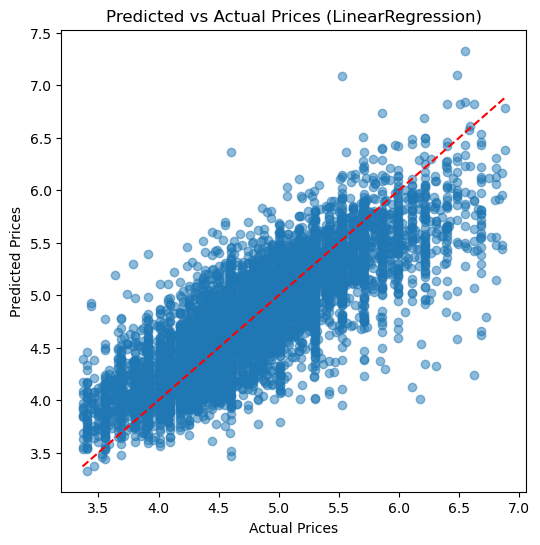

In [4]:
# Select best model (lowest RMSE)
best_model = min(results, key=lambda k: results[k]["RMSE"])
print("Best model selected:", best_model)

# Retrain best model on Train + Valid
final_pipe = Pipeline([("preprocess", preprocess), ("model", models[best_model])])
final_pipe.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]))

# Predict on Test
test_preds = final_pipe.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, test_preds)
rmse = np.sqrt(mean_squared_error(y_test, test_preds))
r2 = r2_score(y_test, test_preds)

print("Test MAE:", mae)
print("Test RMSE:", rmse)
print("Test R²:", r2)

# Visualization
plt.figure(figsize=(6,6))
plt.scatter(y_test, test_preds, alpha=0.5)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title(f"Predicted vs Actual Prices ({best_model})")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

## 4.Final Report Insights and Recommendations

**Key Insights**:
- Listing price mainly depends on room type and location.

- More amenities and good reviews boost pricing.

- Remove outliers (extremely high prices) to improve model accuracy.

**Recommendations for hosts:**
- Add key amenities (Wi-Fi, AC, kitchen) to raise value.

- Motivate guests to leave positive reviews.

- Set prices based on local competition and demand.

- Use dynamic pricing for weekends, holidays, and events.

# PROJECT VIDEO  EXPLANATION LINK:

 " https://www.loom.com/share/d9b3bf47335d43b1ab97fe6de4604923 "